In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, wandb, os, logging, json, random
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

In [4]:
path = '/data/jlai/dark_photon/BDT_input.csv'
df = pd.read_csv(path)
df[df.metsig <= 16].describe()

,metsig,metsigres,met,met_noJVT,dmet,ph_pt,ph_eta,ph_phi,jet_central_eta,jet_central_pt1,...,jetterm,jetterm_sumet,n_jet_central,dphi_met_central_jet,balance,dphi_jj,BDTScore,mt,weights,label
count,54171.000000,5.417100e+04,5.417100e+04,5.417100e+04,54171.000000,5.417100e+04,54171.000000,54171.000000,54171.000000,5.417100e+04,...,5.417100e+04,5.417100e+04,54171.000000,54171.000000,54171.000000,54171.000000,54171.000000,54171.000000,54171.000000,54171.000000
mean,11.147848,1.908873e+04,2.145334e+05,2.153483e+05,814.902776,1.305159e+05,0.813381,0.016555,-0.994041,2.644790e+05,...,2.984079e+05,3.520224e+05,2.217478,1.744184,0.128966,-298.487522,0.275510,154.582107,0.093830,0.039431
std,2.397277,9.030397e+03,1.067421e+05,1.069954e+05,6108.582889,1.623350e+05,0.488004,1.818246,31.545722,2.013720e+05,...,2.043423e+05,2.320469e+05,1.019280,31.613567,31.564124,458.067610,0.053863,54.292638,0.694106,0.194619
min,7.000263,1.046823e+04,1.000023e+05,8.257015e+04,-19999.797000,5.000342e+04,0.000034,-3.141541,-999.000000,-9.990000e+02,...,5.438944e+04,5.438944e+04,0.000000,-999.000000,-999.000000,-999.000000,0.100074,95.001150,-6.165746,0.000000
25%,9.149445,1.457356e+04,1.464107e+05,1.470409e+05,0.000000,6.613580e+04,0.400840,-1.557098,-0.834955,1.588933e+05,...,1.901045e+05,2.181376e+05,1.000000,2.606652,0.968207,-999.000000,0.243966,115.877575,0.014214,0.000000
50%,10.940960,1.738856e+04,1.925596e+05,1.934406e+05,0.000000,8.886838e+04,0.793094,0.024564,0.001748,2.205524e+05,...,2.537773e+05,2.999514e+05,2.000000,2.782094,1.084407,0.505568,0.283316,140.959780,0.042308,0.000000
75%,13.066610,2.160737e+04,2.580474e+05,2.591867e+05,0.000000,1.355009e+05,1.187164,1.584912,0.830955,3.136473e+05,...,3.469417e+05,4.195550e+05,3.000000,2.934042,1.223469,1.274833,0.314783,177.978700,0.111019,0.000000
max,15.998769,1.394890e+06,1.212000e+07,1.212000e+07,49947.516000,3.875383e+06,1.749990,3.141564,2.499738,4.422654e+06,...,4.394674e+06,5.107923e+06,4.000000,3.141564,19.833539,2.499836,0.423485,924.276300,111.573890,1.000000


In [5]:
path = '/data/jlai/dark_photon/BDT_input.csv'
df = pd.read_csv(path)
# df = df[df.dphi_phterm_jetterm >= 1.80]
df = df[df.metsig <= 16]

Vars = [
    'metsig', 'metsigres', 'met', 'met_noJVT', 'dmet', 'ph_pt', 'ph_eta', 'ph_phi',
    'jet_central_eta', 'jet_central_pt1', 'jet_central_pt2', 'dphi_met_phterm', 'dphi_met_ph',
    'dphi_met_jetterm', 'dphi_phterm_jetterm', 'dphi_ph_centraljet1', 'metplusph', 'failJVT_jet_pt1',
    'softerm', 'jetterm', 'jetterm_sumet', 'dphi_met_central_jet', 'balance', 'dphi_jj', 'BDTScore'
]

Vars2 = [
    'metsig', 'met', 'met_noJVT', 'dmet', 'dphi_met_phterm','dphi_ph_centraljet1',
    'dphi_phterm_jetterm', 'jetterm', 'dphi_met_central_jet', 'BDTScore', 'weights', 'label',
]

Vars3 = [
    'metsigres', 'ph_pt', 'ph_eta', 'dphi_met_jetterm', 'failJVT_jet_pt1', 'n_jet_central', 'dphi_jj'
]

df_Vars2 = df[Vars2].copy()
df_Vars3 = df[Vars3].copy()
df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

display(df_ml_input.describe())

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

Number of event with negative weights : 4115


,metsig,met,met_noJVT,dmet,dphi_met_phterm,dphi_ph_centraljet1,dphi_phterm_jetterm,jetterm,dphi_met_central_jet,BDTScore,weights,label,metsigres,ph_pt,ph_eta,dphi_met_jetterm,failJVT_jet_pt1,n_jet_central,dphi_jj
count,54171.000000,5.417100e+04,5.417100e+04,54171.000000,54171.000000,54117.000000,54171.000000,5.417100e+04,54117.000000,54171.000000,54171.000000,54171.000000,5.417100e+04,5.417100e+04,54171.000000,54171.000000,11899.000000,54122.000000,37946.000000
mean,11.147848,2.145334e+05,2.153483e+05,814.902776,1.966114,2.312153,2.328204,2.984079e+05,2.742764,0.275510,0.126629,0.039431,5.722037e-05,1.115141e-05,5.277777,3.480190,0.000039,0.573307,5.413949
std,2.397277,1.067421e+05,1.069954e+05,6108.582889,0.378122,0.437812,0.352038,2.043423e+05,0.274832,0.053863,0.688877,0.194619,1.507329e-05,4.847966e-06,145.891758,2.122032,0.000008,0.289423,163.761176
min,7.000263,1.000023e+05,8.257015e+04,-19999.797000,1.350051,0.025696,1.378738,5.438944e+04,0.038584,0.100074,0.000000,0.000000,7.169022e-07,2.580390e-07,0.571432,1.428635,0.000017,0.250000,0.400026
25%,9.149445,1.464107e+05,1.470409e+05,0.000000,1.647025,2.017110,2.054518,1.901045e+05,2.607481,0.243966,0.020116,0.000000,4.628050e-05,7.380023e-06,0.842343,2.105959,0.000034,0.333333,0.628560
50%,10.940960,1.925596e+05,1.934406e+05,0.000000,1.946550,2.326760,2.315524,2.537773e+05,2.782353,0.283316,0.050757,0.000000,5.750906e-05,1.125260e-05,1.260885,2.872242,0.000040,0.500000,1.094850
75%,13.066610,2.580474e+05,2.591867e+05,0.000000,2.253356,2.641279,2.598225,3.469417e+05,2.934246,0.314783,0.120686,0.000000,6.861742e-05,1.512040e-05,2.494760,4.155506,0.000045,1.000000,2.200818
max,15.998769,1.212000e+07,1.212000e+07,49947.516000,3.080134,3.141469,3.141593,4.394674e+06,3.141564,0.423485,111.573890,1.000000,9.552714e-05,1.999863e-05,29733.885000,58.997180,0.000050,1.000000,27594.105262


Number of nan in each variable: 
metsig                      0
met                         0
met_noJVT                   0
dmet                        0
dphi_met_phterm             0
dphi_ph_centraljet1        54
dphi_phterm_jetterm         0
jetterm                     0
dphi_met_central_jet       54
BDTScore                    0
weights                     0
label                       0
metsigres                   0
ph_pt                       0
ph_eta                      0
dphi_met_jetterm            0
failJVT_jet_pt1         42272
n_jet_central              49
dphi_jj                 16225
dtype: int64


In [6]:
print(sum(df_ml_input[df_ml_input.label==1]['weights']))
print(sum(df_ml_input[df_ml_input.label==0]['weights']))

216.1648599860132
6643.467006253268


random number:  79


Best parameters found: {'gamma': 0.487775807119773, 'learning_rate': 0.033344266612338413, 'max_depth': 7, 'n_estimators': 399, 'subsample': 0.894792622158826}


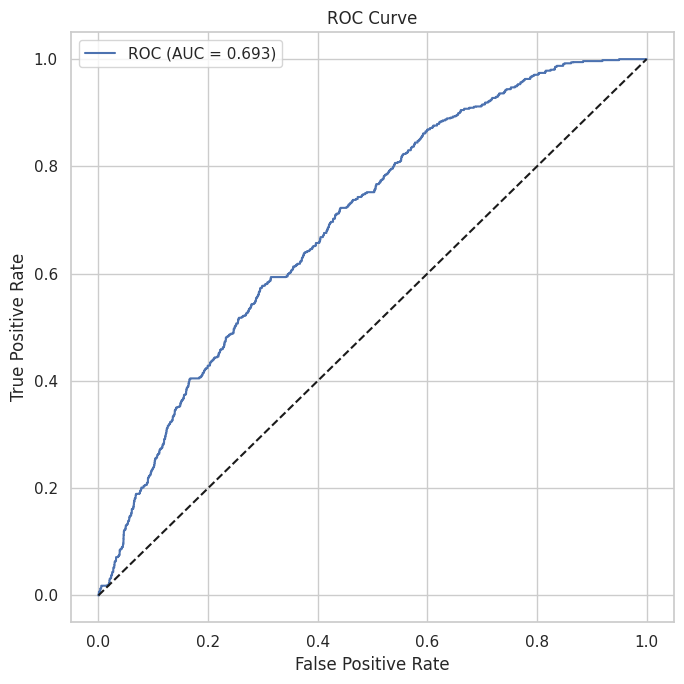

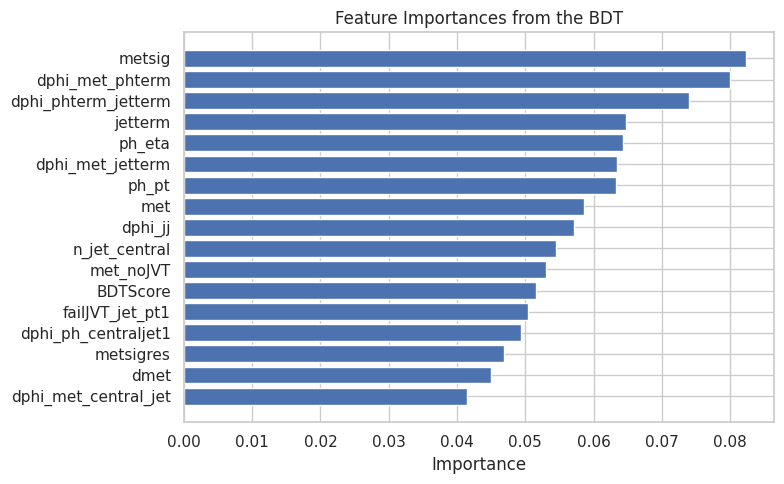

Best CV neg_log_loss,▁
Test Accuracy,▁
Test LogLoss,▁
Test ROC AUC,▁
Train Accuracy,▁
Train LogLoss,▁
Train ROC AUC,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
test_auc,▁▃▃▄▅▅▆▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
test_error,█▇▇▅▃▂▂▂▁▁▂▃▄▃▃▄▃▃▂▂▃▃▃▂▃▂▂▃▂▂▂▃▂▁▁▁▃▃▂▁
test_logloss,██▇▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


In [11]:
# Define X (features) and y (labels)
X = df_ml_input.drop(['label', 'weights'], axis=1)
y = df_ml_input['label']
weights = df_ml_input['weights']

# Reweight signal so that total signal weight = total background weight
sig_mask = df_ml_input['label'] == 1
bkg_mask = df_ml_input['label'] == 0

sum_sig = df_ml_input.loc[sig_mask, 'weights'].sum()
sum_bkg = df_ml_input.loc[bkg_mask, 'weights'].sum()

scale_factor = sum_bkg / sum_sig if sum_sig > 0 else 1.0
df_ml_input.loc[sig_mask, 'weights'] *= scale_factor

random_num = random.randint(1, 100)
print("random number: ", random_num)

X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=random_num, stratify=y)

wandb.init(project="Dark_ph BDT Random", reinit=True, resume=False)

param_distributions = {
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.001, 0.1),
    'n_estimators': randint(100, 500),
    'subsample': uniform(0.8, 0.2),
    'gamma': uniform(0.1, 1),               # higher = more pruning
}

xgb_clf = XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric=['logloss', 'error', 'auc'],
    early_stopping_rounds=10,
    missing=np.nan,  # Let XGBoost handle any remaining NaNs
    random_state=random_num
)

random_search = RandomizedSearchCV(
    xgb_clf, param_distributions, n_iter=20, scoring='roc_auc', refit=True,
    cv=5, n_jobs=-1, random_state=random_num
)

random_search.fit(X_train, y_train,
          sample_weight=sw_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          sample_weight_eval_set=[sw_train, sw_test],
          verbose=False)

best_model = random_search.best_estimator_
wandb.config.update(random_search.best_params_)
wandb.log({"Best CV neg_log_loss": random_search.best_score_})
print("Best parameters found:", random_search.best_params_)

results = best_model.evals_result()
train_loss = results['validation_0']['logloss']
test_loss = results['validation_1']['logloss']
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
train_auc = results['validation_0']['auc']
test_auc = results['validation_1']['auc']

for i, (train_l, test_l, train_e, test_e, train_a, test_a) in enumerate(zip(train_loss, test_loss, train_error, test_error, train_auc, test_auc)):
    wandb.log({
        "train_logloss": train_l,
        "test_logloss": test_l,
        "train_error": train_e,
        "test_error": test_e,
        "train_auc": train_a,
        "test_auc": test_a,
        "iteration": i
    })

y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

metrics = {
    "Train LogLoss": log_loss(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test LogLoss": log_loss(y_test, y_test_pred_proba, sample_weight=sw_test),
    "Train Accuracy": accuracy_score(y_train, y_train_pred),
    "Test Accuracy": accuracy_score(y_test, y_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, y_train_pred_proba, sample_weight=sw_train),
    "Test ROC AUC": roc_auc_score(y_test, y_test_pred_proba, sample_weight=sw_test)
}

wandb.log(metrics)

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba, sample_weight=sw_test)
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label="ROC (AUC = {:.3f})".format(metrics["Test ROC AUC"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("roc_randomsearch.png")
wandb.log({"ROC Curve": wandb.Image("roc_randomsearch.png")})
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)
selected_columns = df_ml_input.drop(['label', 'weights'], axis=1).columns

plt.figure(figsize=(8, 5))
plt.barh(range(len(selected_columns)), importances[indices], align='center')
plt.yticks(range(len(selected_columns)), [selected_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')
plt.tight_layout()
plt.savefig("feature_importance.png")
wandb.log({"Feature Importance": wandb.Image("feature_importance.png")})
plt.show()

wandb.finish()